In [1]:
# ch4/ch4_3_cnn/cnn.ipynb
# 标准库
import sys

# 第三方库
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import plot_model

# 自定义模块
sys.path.append('./../../')
import utils.dataset as d
import utils.metrics as m
import utils.plot as p

# 绘图参数
name_model = 'CNN'
name_var = '电力负荷'
name_unit = ' (MW)'
p.set_matplotlib(plot_dpi=80, save_dpi=600, font_size=12)


,序列长度,最大值,最小值,均值,标准差,偏度,峰度
0,1000,4818.55,2337.89,3445.21,643.33,-0.03,-1.24


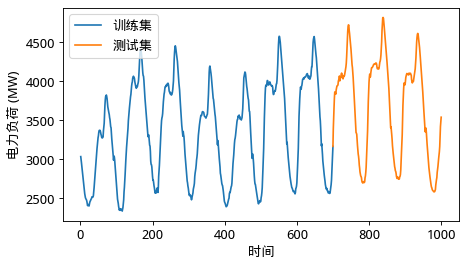

train.shape=(696, 5), test.shape=(300, 5)
train_x.shape=(696, 4), train_y.shape=(696, 1)
test_x.shape=(300, 4), test_y.shape=(300, 1)
train_x_n.shape=(696, 4), train_y_n.shape=(696, 1)
test_x_n.shape=(300, 4), test_y_n.shape=(300, 1)
train_x_n.shape=(696, 4, 1), train_y_n.shape=(696, 1)
test_x_n.shape=(300, 4, 1), test_y_n.shape=(300, 1)


In [2]:
# 数据读取和统计分析
data = pd.read_csv('./data/data_power_demand.csv')
series = data['IE Demand'].values[:, np.newaxis]
ratio_train = 0.7  # 训练样本比例
num_train = int(len(series)*ratio_train)  # 训练样本数量
d.stats(series)
p.plot_dataset(
    train=series[0:num_train],
    test=series[num_train:],
    xlabel='时间',
    ylabel=f'{name_var}{name_unit}',
    fig_name=f'{name_model}_序列'
)

# 监督学习样本构建
H = 4
S = 1
D = 1
train = d.series_to_supervised(series[0:num_train], H, S)  # [num_train, H+1]
test = d.series_to_supervised(series[num_train-H:], H, S)  # [num_test, H+1]
print(f'{train.shape=}, {test.shape=}')

# 训练测试样本划分
train_x = train.iloc[:, :-1].values  # [num_train, H]
train_y = train.iloc[:, -1].values[:, np.newaxis]  # [num_train, 1]
test_x = test.iloc[:, :-1].values  # [num_test, H]
test_y = test.iloc[:, -1].values[:, np.newaxis]  # [num_test, 1]
print(f'{train_x.shape=}, {train_y.shape=}')
print(f'{test_x.shape=}, {test_y.shape=}')

# 样本归一化
x_scalar = MinMaxScaler(feature_range=(0, 1))
y_scalar = MinMaxScaler(feature_range=(0, 1))
train_x_n = x_scalar.fit_transform(train_x)  # [num_train, H]
test_x_n = x_scalar.transform(test_x)  # [num_test, H]
train_y_n = y_scalar.fit_transform(train_y)  # [num_train, 1]
test_y_n = y_scalar.transform(test_y)  # [num_test, 1]
print(f'{train_x_n.shape=}, {train_y_n.shape=}')
print(f'{test_x_n.shape=}, {test_y_n.shape=}')

# 数据重构
train_x_n = train_x_n.reshape(
    train_x_n.shape[0],
    train_x_n.shape[1],
    D)  # [num_train, H] -> [num_train, H, D], D = 1
test_x_n = test_x_n.reshape(
    test_x_n.shape[0],
    test_x_n.shape[1],
    D)  # [num_test, H] -> [num_test, H, D], D = 1
print(f'{train_x_n.shape=}, {train_y_n.shape=}')
print(f'{test_x_n.shape=}, {test_y_n.shape=}')


In [3]:
# 模型构建
model = Sequential()
model.add(Conv1D(  # 一维CNN层
    filters=64, 
    kernel_size=2,
    activation='relu', 
    input_shape=(H, D)
))
model.add(MaxPooling1D(pool_size=2))  # 最大池化层
model.add(Flatten())  # 展开层
model.add(Dense(32, activation='relu'))  # Dense层
model.add(Dense(1, activation='linear'))  # 输出层

# 优化器
opt = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=False
)

# 损失函数
loss = MeanSquaredError()

# 模型编译
model.compile(optimizer=opt, loss=loss)

# 学习率调度器
callback = ReduceLROnPlateau(  # 损失不再改善时降低学习率
    monitor='loss',
    factor=0.2,
    patience=20,
    verbose=1,
    mode='auto',
    min_delta=1E-5,
    cooldown=10,
    min_lr=1E-6
)

# 训练集-训练
history = model.fit(
    train_x_n,  # 训练集特征
    train_y_n,  # 训练集标签
    epochs=100,  # 迭代次数
    batch_size=16,  # Mini-Batch
    verbose=0,  # 不显示过程
    shuffle=False,  # 不打乱样本
    callbacks=callback  # 回调函数
)

# 模型查看
plot_model(
    model, 
    to_file=f'./fig/{name_model}_模型结构.jpg',
    show_shapes=True,  # 显示数据维度/形状
    show_dtype=True,  # 显示数据类型
    dpi=600
)

# 测试集-预测
y_hat_n = model.predict(
    test_x_n,  # 测试集特征
    verbose=0  # 不显示过程
)
y_hat = y_scalar.inverse_transform(y_hat_n)  # [num_test, 1]

# 测试集-误差计算
m.all_metrics(y_true=test_y, y_pred=y_hat)


2022-12-03 17:39:03.196751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 17:39:03.203476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 17:39:03.204152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 17:39:03.204904: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

mse=16948.455
rmse=130.186
mae=110.555
mape=2.883%
sde=72.461
r2=0.959
pcc=0.995


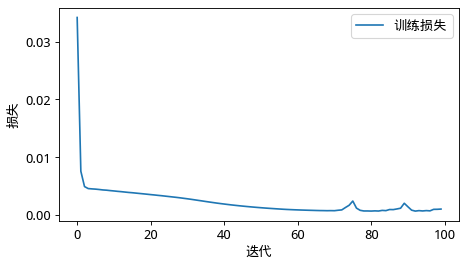

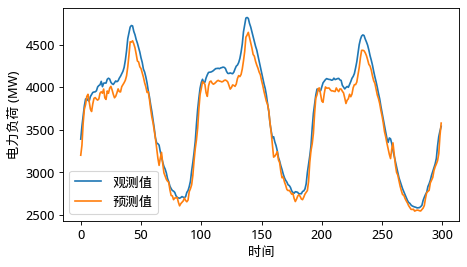

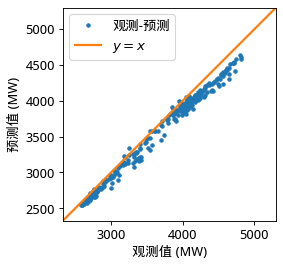

In [4]:
# 可视化
p.plot_losses(
    train_loss=history.history['loss'],
    xlabel='迭代',
    ylabel='损失',
    fig_name=f'{name_model}_损失'
)
p.plot_results(
    y_true=test_y,
    y_pred=y_hat,
    xlabel='时间',
    ylabel=f'{name_var}{name_unit}',
    fig_name=f'{name_model}_预测曲线'
)
p.plot_parity(
    y_true=test_y,
    y_pred=y_hat,
    xlabel=f'观测值{name_unit}',
    ylabel=f'预测值{name_unit}',
    fig_name=f'{name_model}_Parity'
)
